# Industrial Equipment Anomaly Detection using Autoencoders

This project aims to detect anomalies in industrial equipment using autoencoders. The dataset used for this project is the CMAPSS dataset, which includes multivariate time series data from engine systems. The objective is to predict the remaining useful life (RUL) of the engines and detect


## Import Libraries and Create Directory

In [23]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tqdm.notebook import tqdm

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Define the directory to save images
image_dir = 'Images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)


## Load and Preprocess Data

We load the data from the provided CSV files and perform necessary preprocessing steps:
- Fill missing values using forward fill (`ffill`) and backward fill (`bfill`).
- Drop any non-numeric columns.
- Standardize the data using `StandardScaler` to ensure the model performs optimally.

We also implement a loading bar using `tqdm` to track progress during data loading.


In [24]:
def load_and_preprocess_data(file_path, scaler=None):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values   # Target (if necessary)
    
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        joblib.dump(scaler, os.path.join(image_dir, 'scaler.pkl'))
    else:
        X_scaled = scaler.transform(X)
    
    return X_scaled, y, scaler

# Load data
train_data, _, scaler = load_and_preprocess_data('CMAPSS_CSV/train_FD001.csv')
test_data, y_test, _ = load_and_preprocess_data('CMAPSS_CSV/test_FD001.csv', scaler)

# Split training data into training and validation sets
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state=42)


## Autoencoder Model Architecture

The autoencoder is a neural network designed to learn efficient representations of the input data. It consists of two main parts:
- **Encoder**: Reduces the dimensionality of the input data.
- **Decoder**: Reconstructs the data back to its original form.

The model is trained to minimize the reconstruction error (Mean Squared Error - MSE).


In [25]:
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)
decoded = Dense(encoding_dim // 2, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


## Model Training

We train the autoencoder model using the training data and validate it on the validation set. The training is monitored using an early stopping callback to prevent overfitting.

**Training Parameters:**
- Epochs: 50
- Batch Size: 256
- Early Stopping: Patience of 10 epochs with `restore_best_weights=True`


In [26]:
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7642 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5105 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4821 - val_loss: 0.4703 - learning_rate: 0.0010
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4708 - val_loss: 0.4541 - learning_rate: 0.0010
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.4622 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.4521 - val_loss: 0.4453 - learning_rate: 0.0010
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4515 - val_loss: 0.4427 - learning_rate: 0.0010
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4494 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4564 - val_loss: 0.4368 - learning_rate: 0.00

###  Model Summary
To get an overview of the autoencoder model's architecture, including the layers and parameters, we use the `summary()` method. This will print a detailed summary of the model's configuration:

In [27]:
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,661 (100.24 KB)

 Trainable params: 8,553 (33.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,108 (66.83 KB)

## Visualizing the Autoencoder Model

In [28]:
def plot_and_save_autoencoder_model(autoencoder, image_dir):
    plot_model(autoencoder, to_file=os.path.join(image_dir, 'autoencoder_model_plot.png'), show_shapes=True, show_layer_names=True)

plot_and_save_autoencoder_model(autoencoder, image_dir)


## Model Performance Visualization

After training, we visualize the model's performance by plotting the training and validation loss over epochs. This helps us understand how well the model has learned to reconstruct the data.


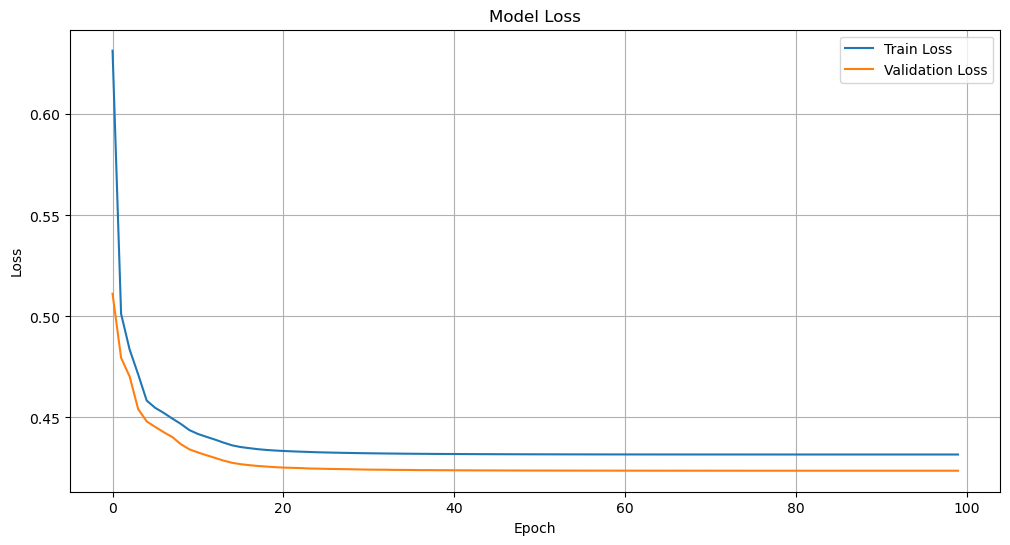

In [29]:
def plot_and_save_history(history, image_dir):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(os.path.join(image_dir, 'training_loss.png'))
    plt.show()  # Display the plot in the notebook

plot_and_save_history(history, image_dir)


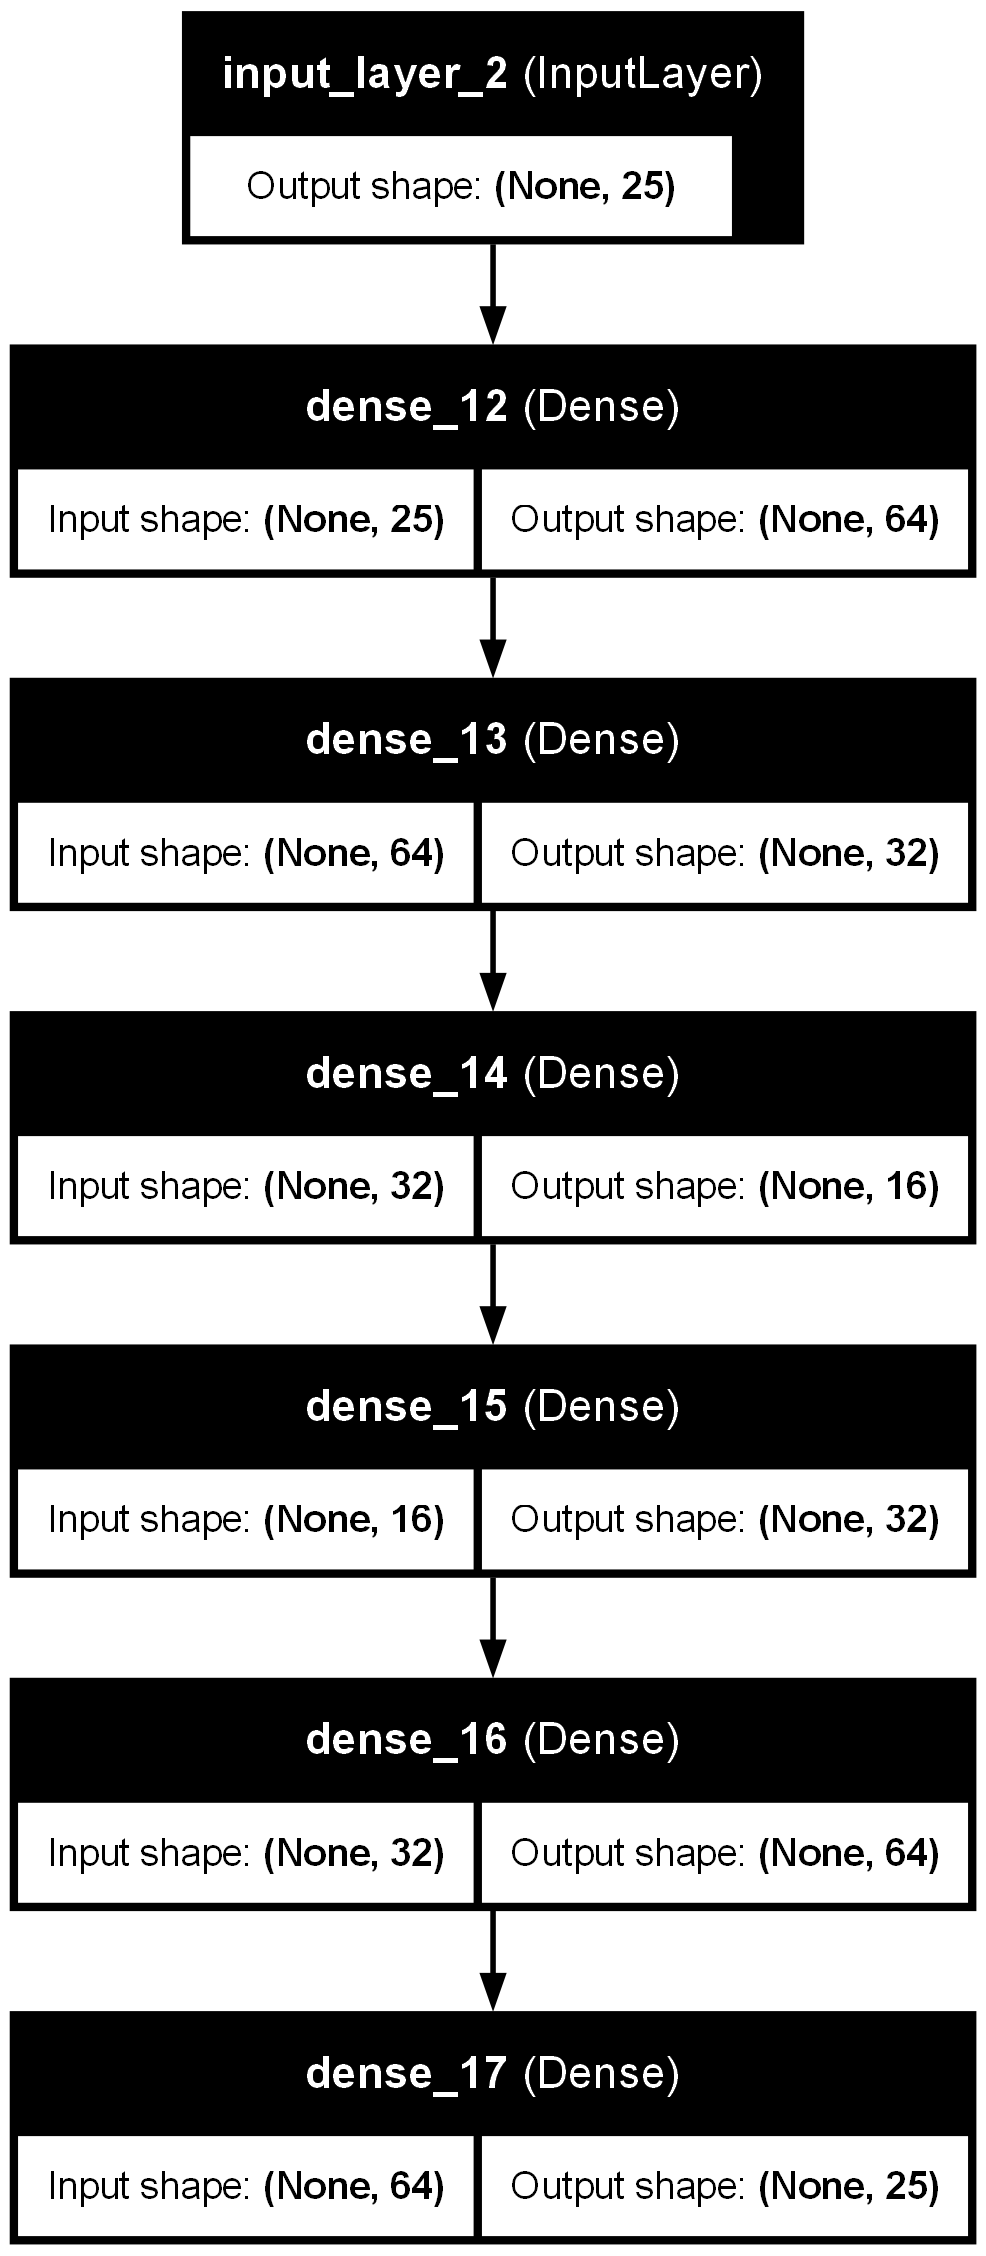

In [30]:
from tensorflow.keras.utils import plot_model

def plot_and_save_autoencoder_model(autoencoder, image_dir):
    plot_model(autoencoder, to_file=os.path.join(image_dir, 'autoencoder_model_plot.png'), show_shapes=True, show_layer_names=True)

plot_and_save_autoencoder_model(autoencoder, image_dir)

# Display the model plot in the notebook
from IPython.display import Image
Image(filename=os.path.join(image_dir, 'autoencoder_model_plot.png'))


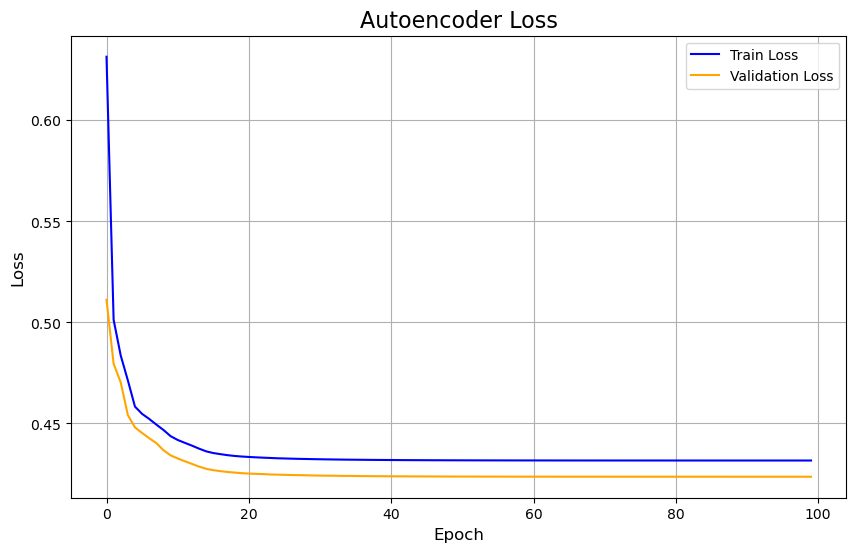

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Autoencoder Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(os.path.join(image_dir, 'autoencoder_loss.png'))
plt.show()  # Display the plot in the notebook


## Anomaly Detection

We use the trained autoencoder to detect anomalies in the test data. Anomalies are detected based on the reconstruction error. We calculate the reconstruction error for each data point and flag the ones that exceed a certain threshold as anomalies.

**Threshold Selection**: We experiment with different thresholds to find the most suitable value for anomaly detection.


In [32]:
# Predict reconstruction error
reconstructed_data = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.square(test_data - reconstructed_data), axis=1)

410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


## Reconstruction Error Distribution

We plot the distribution of reconstruction errors to visualize how the errors are spread. This helps in selecting a suitable threshold for anomaly detection.


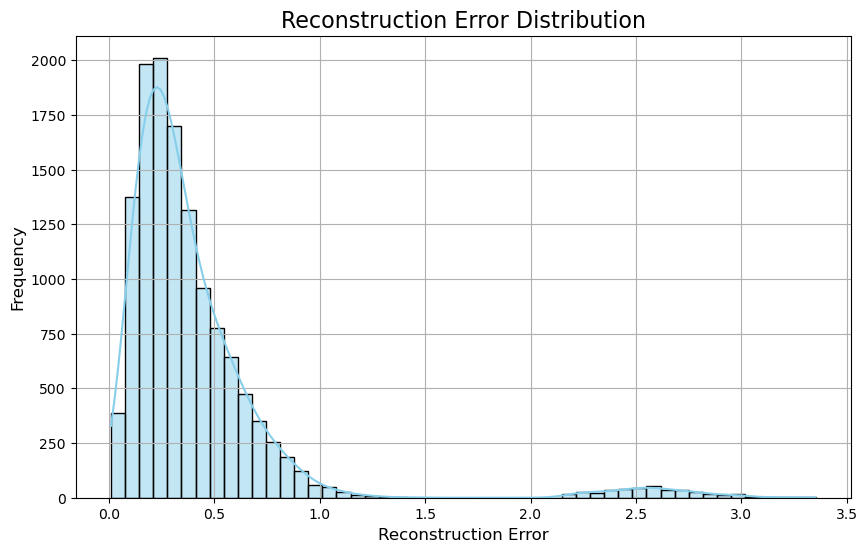

In [33]:
## Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True, color='skyblue')
plt.title('Reconstruction Error Distribution', fontsize=16)
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(image_dir, 'reconstruction_error_distribution.png'))
plt.show()  # Display the plot in the notebook


## Threshold Experimentation

We experiment with different thresholds for anomaly detection and observe how the number of detected anomalies changes. This helps us tune the sensitivity of the anomaly detection system.


In [34]:
# Set a threshold for anomaly detection based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # 95th percentile as an example
anomalies = reconstruction_error > threshold

print(f'Number of detected anomalies: {np.sum(anomalies)}')

Number of detected anomalies: 655


Threshold: 0.7060 | Number of anomalies: 1310


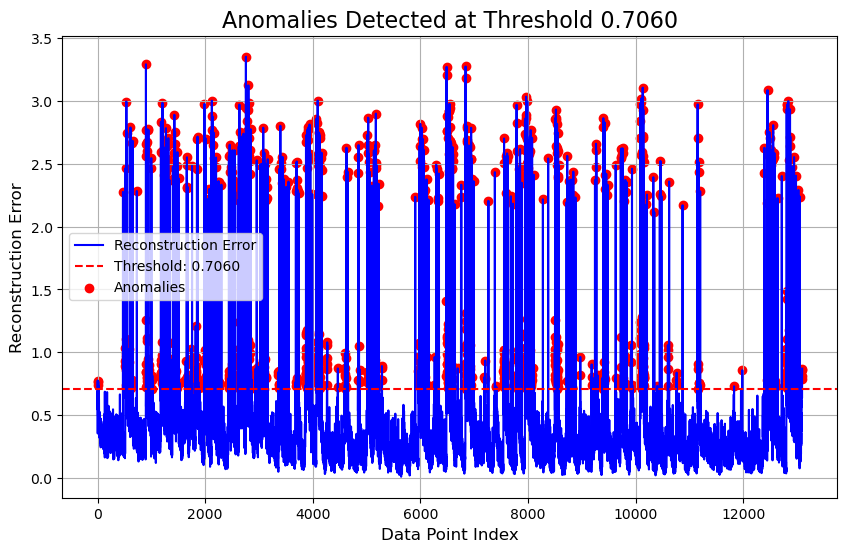

Threshold: 0.8904 | Number of anomalies: 655


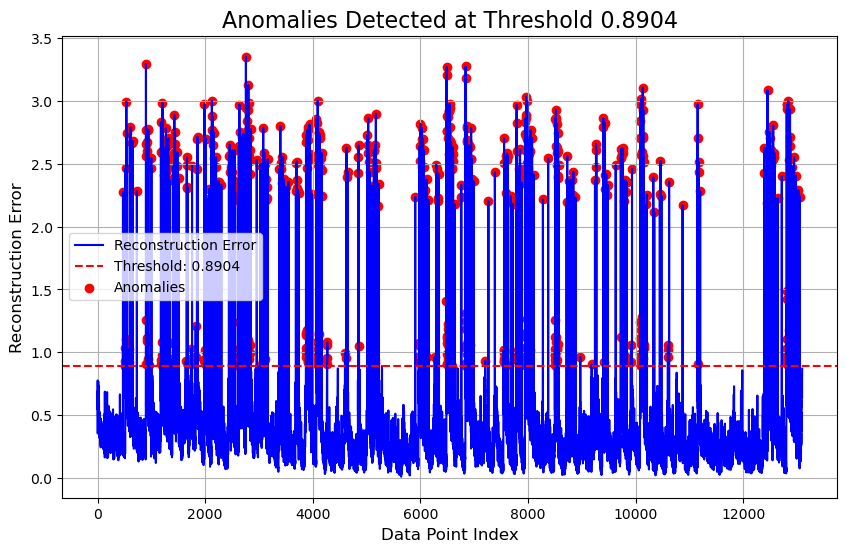

Threshold: 1.4317 | Number of anomalies: 393


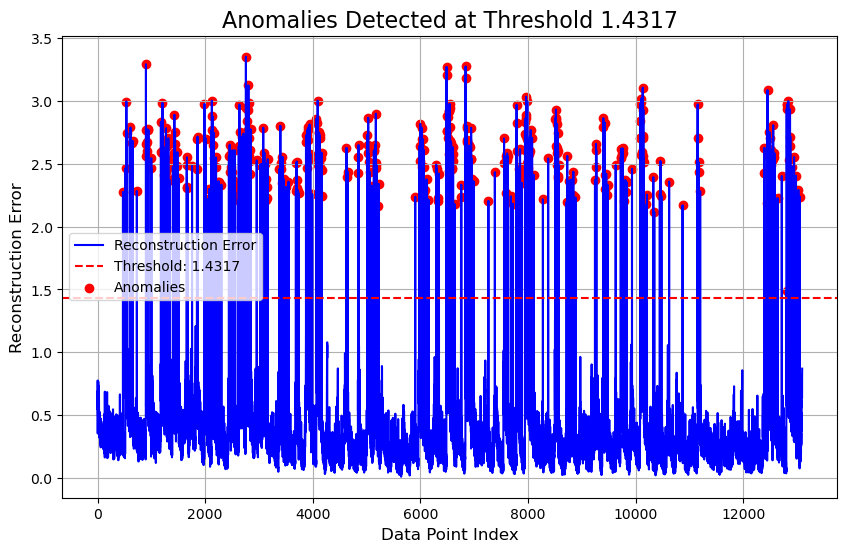

Threshold: 2.6572 | Number of anomalies: 131


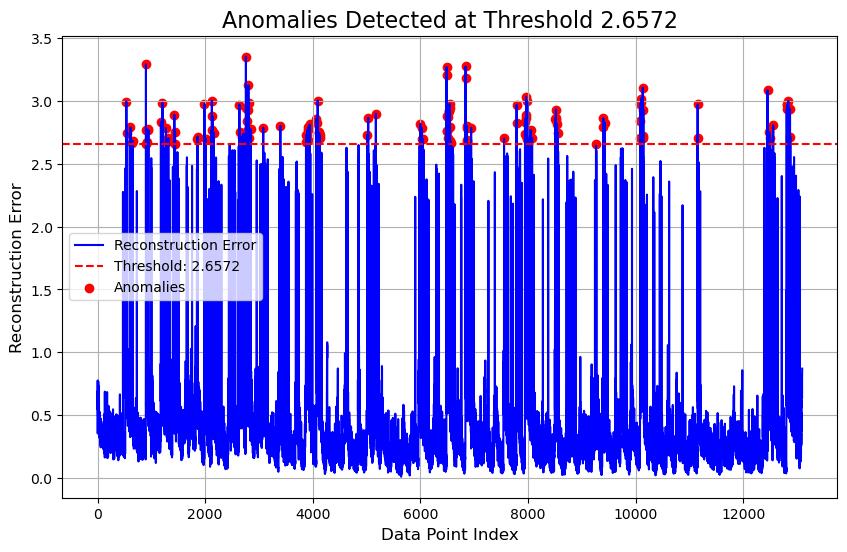

In [35]:
# Experiment with different thresholds
thresholds = [np.percentile(reconstruction_error, p) for p in [90, 95, 97, 99]]
for th in thresholds:
    anomalies = reconstruction_error > th
    print(f'Threshold: {th:.4f} | Number of anomalies: {np.sum(anomalies)}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(y=th, color='red', linestyle='--', label=f'Threshold: {th:.4f}')
    plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='red', label='Anomalies')
    plt.title(f'Anomalies Detected at Threshold {th:.4f}', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=12)
    plt.ylabel('Reconstruction Error', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()  # Display the plot in the notebook

## Model Evaluation

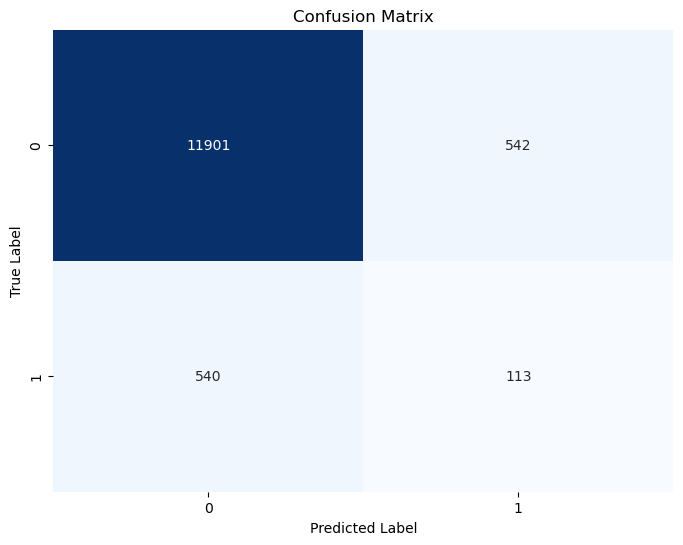

In [36]:
def plot_and_save_confusion_matrix(y_true, y_pred, image_dir):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(os.path.join(image_dir, 'confusion_matrix.png'))
    plt.show()  # Display the plot in the notebook

threshold_y_test = np.percentile(y_test, 95)
y_test_binary = (y_test > threshold_y_test).astype(int)
y_pred = (reconstruction_error > np.percentile(reconstruction_error, 95)).astype(int)
plot_and_save_confusion_matrix(y_test_binary, y_pred, image_dir)




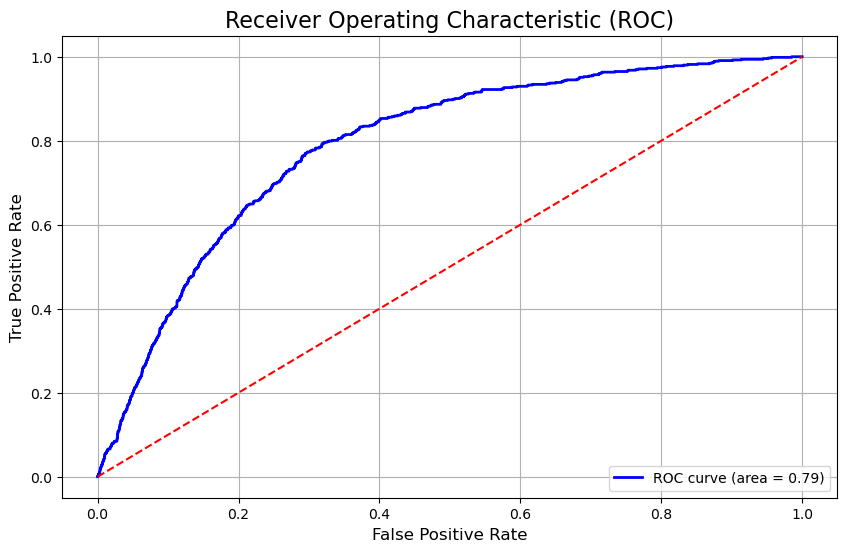

In [37]:
def plot_and_save_roc_curve(y_true, y_scores, image_dir):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(os.path.join(image_dir, 'roc_curve.png'))
    plt.show()  # Display the plot in the notebook

plot_and_save_roc_curve(y_test_binary, reconstruction_error, image_dir)


In [38]:
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.1725
Recall: 0.1730
F1-Score: 0.1728


## Conclusion

In this project, we successfully built an autoencoder model to detect anomalies in industrial equipment data. By experimenting with different thresholds, we were able to fine-tune the model's sensitivity to anomalies. Future work could involve testing the model on other datasets or further tuning the model architecture for improved performance.
